## mRKS method

Please check the original paper:\
\[1\] [Ryabinkin, Kohut and Staroverov, PRL 115, 083001 (2015)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.083001) \
\[2\] [Ospadov, Ryabinkin and Staroverov, J. Chem. Phys. 146, 084103 (2017)](https://doi.org/10.1063/1.4975990) \
\[3\] [Staroverov, Ospadov, Advances in Quantum Chemistry, Volume 79 (2019)](https://doi.org/10.1016/bs.aiq.2019.04.002).

First, build the input wavefunction using Psi4. Note that currently only Psi4.CIWavefunction supports two-particle density matrices (tpdm). CISD is used in this example.

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({"save_jk" : True})
psi4.set_memory(int(2.50e9))
psi4.core.clean()

import n2v

In [2]:
Ne = psi4.geometry( 
""" 
0 1
Ne
noreorient
nocom
units bohr
symmetry c1
""" )

psi4.set_options({"reference" : "rhf",
                  "opdm": True,
                  "tpdm": True,
                  'DFT_SPHERICAL_POINTS': 350,  # Usually specify the DFT spherical grid is highly recommended.
                  'DFT_RADIAL_POINTS': 44,  # See [https://psicode.org/psi4manual/master/dft.html] for options.
                 })  # Spin-Restricted

# IMPORTANT NOTE: ONLY psi4.CIWavefunction or RHF is supported.
wfn = psi4.properties("cisd/cc-pvdz", return_wfn=True, molecule=Ne, property=['dipole'])[1]

ine = n2v.Inverter(wfn)

Let's first try calculating $v_{xc}$ on DFT shperical grid.\
This grid is automatically generated by Psi4 for doing DFT vxc integrals.

In [3]:
v = ine.invert("mRKS", opt_max_iter=50, frac_old=0.3)

The guide potential is changed to v_hartree.
Memory taken by ERI integral matrix and 2pdm is about: 0.001 GB.
vxchole quadrature double integral starts (13300 points): ...........

Totally 13300 grid points takes 46.10s with max 256 points in a block.
Iter: 1, Density Error: 8.91e-03, Eigenvalue Error: 5.32e+00, Potential Error: 1.34e+00.
Iter: 2, Density Error: 6.25e-03, Eigenvalue Error: 6.00e-01, Potential Error: 1.11e+00.
Iter: 3, Density Error: 4.97e-03, Eigenvalue Error: 2.54e-01, Potential Error: 8.67e-01.
Iter: 4, Density Error: 3.58e-03, Eigenvalue Error: 1.67e-01, Potential Error: 6.62e-01.
Iter: 5, Density Error: 2.85e-03, Eigenvalue Error: 1.46e-01, Potential Error: 5.13e-01.
Iter: 6, Density Error: 2.16e-03, Eigenvalue Error: 9.95e-02, Potential Error: 3.97e-01.
Iter: 7, Density Error: 1.70e-03, Eigenvalue Error: 8.70e-02, Potential Error: 3.10e-01.
Iter: 8, Density Error: 1.32e-03, Eigenvalue Error: 6.00e-02, Potential Error: 2.41e-01.
Iter: 9, Density Error: 1.03e-03, Ei

In [4]:
x,y,z,_ = ine.Vpot.get_np_xyzw()

mask = np.bitwise_and(np.isclose(y, 0), np.isclose(z,0))
order = np.argsort(x[mask])

x_plot = x[mask][order]
vxc_plot = v[0][mask][order]

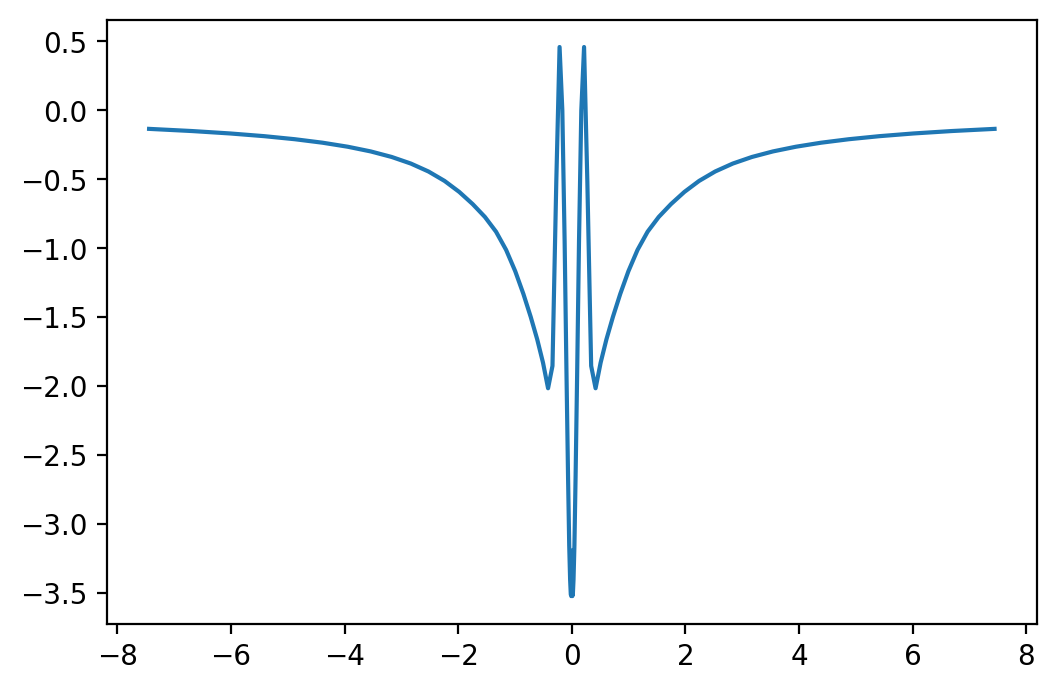

In [5]:
fig, ax = plt.subplots(dpi=200)
ax.plot(x_plot, vxc_plot)

If a user specified grid is needed (which is usually the case), one should give the grid infomation before the calculation, as shown following:

In [6]:
x = np.linspace(-5,5,1001)
y = [0]
z = [0]
grid, shape = ine.generate_grids(x,y,z)
grid.shape

(3, 1001)

In [7]:
v = ine.invert("mRKS", opt_max_iter=50, frac_old=0.3, vxc_grid=grid)

The guide potential is changed to v_hartree.
Memory taken by ERI integral matrix and 2pdm is about: 0.001 GB.
Iter: 1, Density Error: 8.91e-03, Eigenvalue Error: 5.32e+00, Potential Error: 1.34e+00.
Iter: 2, Density Error: 6.25e-03, Eigenvalue Error: 6.00e-01, Potential Error: 1.11e+00.
Iter: 3, Density Error: 4.97e-03, Eigenvalue Error: 2.54e-01, Potential Error: 8.67e-01.
Iter: 4, Density Error: 3.58e-03, Eigenvalue Error: 1.67e-01, Potential Error: 6.62e-01.
Iter: 5, Density Error: 2.85e-03, Eigenvalue Error: 1.46e-01, Potential Error: 5.13e-01.
Iter: 6, Density Error: 2.16e-03, Eigenvalue Error: 9.95e-02, Potential Error: 3.97e-01.
Iter: 7, Density Error: 1.70e-03, Eigenvalue Error: 8.70e-02, Potential Error: 3.10e-01.
Iter: 8, Density Error: 1.32e-03, Eigenvalue Error: 6.00e-02, Potential Error: 2.41e-01.
Iter: 9, Density Error: 1.03e-03, Eigenvalue Error: 5.34e-02, Potential Error: 1.90e-01.
Iter: 10, Density Error: 8.11e-04, Eigenvalue Error: 3.63e-02, Potential Error: 1.47e-01.

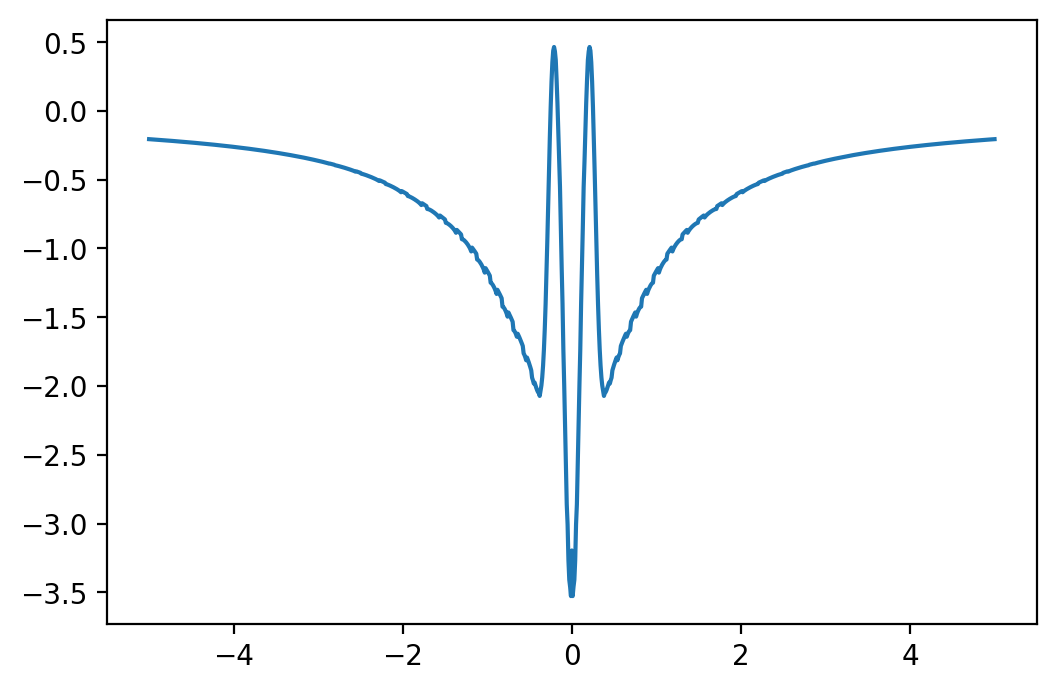

In [8]:
fig, ax = plt.subplots(dpi=200)
ax.plot(x, v[0])